In [88]:
import os
from fastai.data.external import untar_data, URLs
import resnet

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor

import numpy as np

import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


Скачиваем датасет CIFAR10

In [89]:


dataset = torchvision.datasets.CIFAR10(root='./data', download=True)

Files already downloaded and verified


In [90]:

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [91]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)

batch_size = 100
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size * 2, num_workers=2, pin_memory=True)

In [92]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


device = get_default_device()
print(device)

trainloader = DeviceDataLoader(trainloader, device)
testloader = DeviceDataLoader(testloader, device)

cuda


In [93]:

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [94]:
class ImageClassificationBase:
    def __init__(self, model: nn.Module, name: str):
        """
        Initialize the model.

        Args:
            model: PyTorch model
            name: Name identifier for the model
        """
        self.model = model.to(device)
        self.name = name
        
    def training_step(self, batch):
        images, labels = batch 
        out = self.model(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        acc = accuracy(out, labels)  
        return loss,acc
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self.model(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['train_accuracy'], result['val_loss'], result['val_acc']))

Создадим папку, чтобы сохранить нашу модель

In [95]:
MODEL_PATH = "models/"
MODEL_EXP_PATH = MODEL_PATH + "bestAcc/"
try:
    os.mkdir(MODEL_PATH)
except:
    print("Folder already exists")

try:
    os.mkdir(MODEL_EXP_PATH)
except:
    print("Folder already exists")

Folder already exists
Folder already exists


Функции тренировки и тестирования

In [96]:
import torch.optim as optim
@torch.no_grad()
def evaluate(model, val_loader):
    net = model.model
    net.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit_one_cycle(epochs, model, train_loader, val_loader, learning_rate):
    history = []
    optimizer = torch.optim.SGD(model.model.parameters(), lr = learning_rate, momentum=0.9)
    best_accuracy=0.0
    best_train_loss = 100
    all_predictions = 0
    correct_predictions = 0
    for epoch in range(epochs):
        # Training Phase 
        model.model.train()
        train_losses = []
        train_accuracy= []
        running_loss = 0.0
        for (batch_idx, batch) in enumerate(train_loader):
            optimizer.zero_grad()

            loss, accuracy = model.training_step(batch)

            train_losses.append(loss)
            train_accuracy.append(accuracy)

            loss.backward()
            optimizer.step()
            
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracy).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        if result['val_acc']>best_accuracy:
            best_accuracy=result['val_acc']
            torch.save(model.model.state_dict(), MODEL_EXP_PATH + "/baseline_"+ model.name +"_accuracy")

        if result['val_loss']<best_train_loss:
            best_train_loss = result['val_loss']
            torch.save(model.model.state_dict(), MODEL_EXP_PATH + "/baseline_"+ model.name +"_loss")
    return history

Функция запуска тренировки и запись результатов

In [97]:
results = dict()
def run(net, epochs = 10, lr = 0.001):
    history = fit_one_cycle(epochs, net, trainloader, testloader, lr)

    plot_accuracies(history, net.name)
    plt.show()
    plot_losses(history, net.name)
    plt.show()

    best_accurate_model = ImageClassificationBase(net.model, "")
    best_accurate_model.model.load_state_dict(torch.load(MODEL_EXP_PATH + "/baseline_"+ net.name +"_accuracy", weights_only = True))

    results[net.name] = evaluate(best_accurate_model, testloader)
    print("best acc in " + net.name)
    print(results[net.name])

Функции для постройки графиков изменения точности и потерь моделей

In [98]:
def plot_accuracies(history, model_name):
    train_accuracies= [x['train_accuracy'] for x in history]
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-bx')
    plt.plot(train_accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['Validation','Training'])
    plt.title("Accuracy of " + model_name)

In [99]:
def plot_losses(history, model_name):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title("Losses of " + model_name)

Модифицируем AlexNet

In [100]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            #nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2.0),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            #nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2.0),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)

            
        )
        self.AdaptiveAvgPool2d = nn.AdaptiveAvgPool2d((4, 4))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.AdaptiveAvgPool2d(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

Модификация встроенной модели alexnet

In [101]:
# class AlexNet(ImageClassificationBase):
#     def __init__(self, num_classes: int) -> None:
#         model = models.alexnet(weights = models.AlexNet_Weights.IMAGENET1K_V1)
#         model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
#         super().__init__(model, "alexNet")

class AlexNetMods(ImageClassificationBase):
    def __init__(self, num_classes: int) -> None:
        model = models.alexnet(weights = models.AlexNet_Weights.IMAGENET1K_V1)
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
        for param in model.parameters():
            param.requires_grad = False

        for param in model.classifier.parameters():
            param.requires_grad = True
        
        super().__init__(model, "alexNet")

Модификация встроенной модели ResNext50_32x4d

In [102]:
class ResNext50(ImageClassificationBase):
    def __init__(self, num_classes: int) -> None:
        model = models.resnext50_32x4d(weights = models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        super().__init__(model, "resNext50")
class ResNext50Mods(ImageClassificationBase):
    def __init__(self, num_classes: int) -> None:
        model = models.resnext50_32x4d(weights = models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        for param in model.parameters():
            param.requires_grad = False
        
        for param in model.fc.parameters():
            param.requires_grad = True
        
        super().__init__(model, "resNext50_mods")

Модификация встроенной модели mobilenet_v2

In [103]:
class MobileNetV2(ImageClassificationBase):
    def __init__(self, num_classes: int) -> None:
        model = models.mobilenet_v2(weights = models.MobileNet_V2_Weights.IMAGENET1K_V2)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        super().__init__(model, "mobilenet_v2")

class MobileNetV2Mods(ImageClassificationBase):
    def __init__(self, num_classes: int) -> None:
        model = models.mobilenet_v2(weights = models.MobileNet_V2_Weights.IMAGENET1K_V2)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        for param in model.parameters():
            param.requires_grad = False
        # for param in model.features[:2].parameters():
        #     param.requires_grad = True
        # for param in model.features[-2:].parameters():
        #     param.requires_grad = True
        for param in model.classifier.parameters():
            param.requires_grad = True
        
        super().__init__(model, "mobilenet_v2_mods")

Модификация встроенной модели shufflenet_v2_x1_0

In [104]:
class ShuffleNetV2(ImageClassificationBase):
    def __init__(self, num_classes: int) -> None:
        model = models.shufflenet_v2_x1_0(weights = models.ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        super().__init__(model, "shufflenet_v2")

class ShuffleNetV2Mods(ImageClassificationBase):
    def __init__(self, num_classes: int) -> None:
        model = models.shufflenet_v2_x1_0(weights = models.ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        for param in model.parameters():
            param.requires_grad = False

        for param in model.fc.parameters():
            param.requires_grad = True
        
        super().__init__(model, "shufflenet_v2_mods")

Модификация встроенной модели inception_v3


In [105]:
class EfficientNetB0(ImageClassificationBase):
    def __init__(self, num_classes: int) -> None:
        model = models.efficientnet_b0(weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        super().__init__(model, "efficient_b1")

class EfficientNetB1Mods(ImageClassificationBase):
    def __init__(self, num_classes: int) -> None:
        model = models.efficientnet_b0(weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
        for param in model.parameters():
            param.requires_grad = False

        for param in model.classifier.parameters():
            param.requires_grad = True
        
        super().__init__(model, "efficient_b1_mods")

Добавим 3 встроенные модели библиотеки pytorch и создадим их

In [106]:
# alex_net = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
# inception_net = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)
# res_next50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnext50_32x4d', pretrained=True)
# shuffle_netv2 = torch.hub.load('pytorch/vision:v0.10.0', 'shufflenet_v2_x1_0', pretrained=True)

alex_net = ImageClassificationBase(AlexNet(10), "alexNet")
res_next50 = ResNext50(10)
mobile_net = MobileNetV2(10)
shuffle_net = ShuffleNetV2(10)
efficient_net = EfficientNetB0(10)
from torchinfo import summary
#summary(alex_net, input_size=(batch_size, 3, 32, 32))
#summary(mobile_net, input_size=(batch_size, 3, 32, 32))
#summary(res_next50, input_size=(batch_size, 3, 32, 32))
#summary(efficient_net.model, input_size=(batch_size, 3, 224, 224))

Параметры обучения

Тренировка моделей без модификаций

In [86]:
epochs = 10
lr = 0.001

AlexNet

Epoch [1], train_loss: 2.3015, train_acc: 0.1090, val_loss: 2.2994, val_acc: 0.1571
Epoch [2], train_loss: 2.2864, train_acc: 0.1219, val_loss: 2.2416, val_acc: 0.1701
Epoch [3], train_loss: 2.1453, train_acc: 0.2180, val_loss: 2.0159, val_acc: 0.2675
Epoch [4], train_loss: 1.9701, train_acc: 0.2702, val_loss: 1.8547, val_acc: 0.3115
Epoch [5], train_loss: 1.8104, train_acc: 0.3231, val_loss: 1.7537, val_acc: 0.3496
Epoch [6], train_loss: 1.6924, train_acc: 0.3724, val_loss: 1.6635, val_acc: 0.3914
Epoch [7], train_loss: 1.6151, train_acc: 0.4019, val_loss: 1.6343, val_acc: 0.4075
Epoch [8], train_loss: 1.5484, train_acc: 0.4275, val_loss: 1.5300, val_acc: 0.4344
Epoch [9], train_loss: 1.4877, train_acc: 0.4506, val_loss: 1.4234, val_acc: 0.4668
Epoch [10], train_loss: 1.4177, train_acc: 0.4786, val_loss: 1.3518, val_acc: 0.5030
Epoch [11], train_loss: 1.3656, train_acc: 0.4996, val_loss: 1.3010, val_acc: 0.5223
Epoch [12], train_loss: 1.3143, train_acc: 0.5197, val_loss: 1.2976, val_a

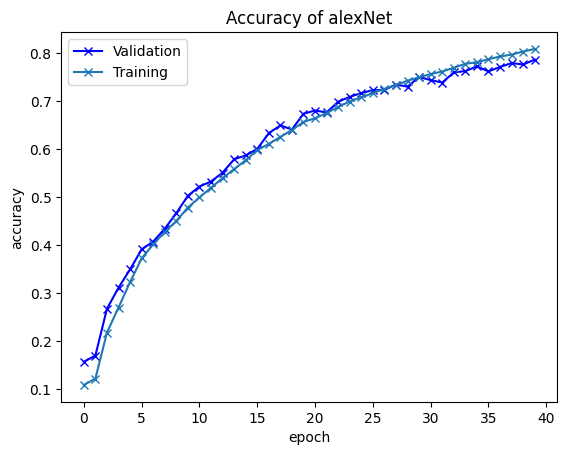

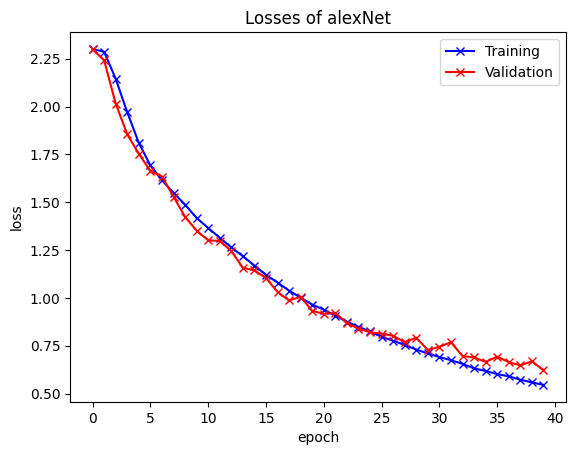

best acc in alexNet
{'val_loss': 0.6214809417724609, 'val_acc': 0.7867000102996826}


In [107]:
run(alex_net, epochs = 40)


Efficient net B0

Epoch [1], train_loss: 1.7443, train_acc: 0.3834, val_loss: 1.2958, val_acc: 0.5509
Epoch [2], train_loss: 1.1984, train_acc: 0.5793, val_loss: 1.0567, val_acc: 0.6282
Epoch [3], train_loss: 0.9941, train_acc: 0.6548, val_loss: 0.9138, val_acc: 0.6840
Epoch [4], train_loss: 0.8740, train_acc: 0.6963, val_loss: 0.8280, val_acc: 0.7142
Epoch [5], train_loss: 0.7877, train_acc: 0.7250, val_loss: 0.7679, val_acc: 0.7350
Epoch [6], train_loss: 0.7171, train_acc: 0.7501, val_loss: 0.7349, val_acc: 0.7468
Epoch [7], train_loss: 0.6645, train_acc: 0.7678, val_loss: 0.7113, val_acc: 0.7551
Epoch [8], train_loss: 0.6203, train_acc: 0.7829, val_loss: 0.6780, val_acc: 0.7689
Epoch [9], train_loss: 0.5795, train_acc: 0.7959, val_loss: 0.6646, val_acc: 0.7741
Epoch [10], train_loss: 0.5498, train_acc: 0.8074, val_loss: 0.6521, val_acc: 0.7758


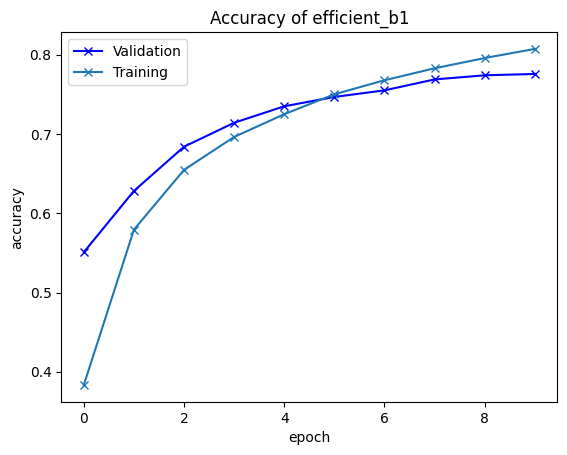

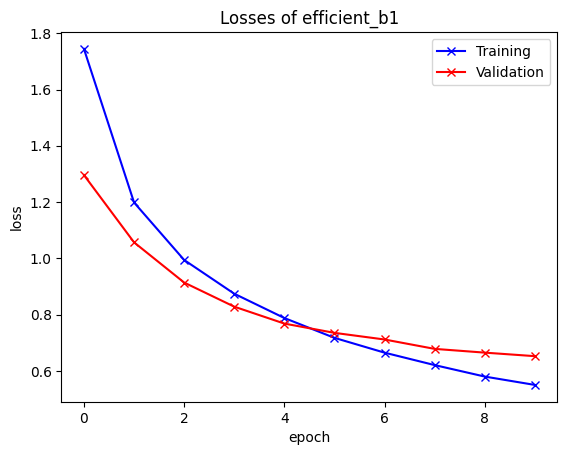

best acc in efficient_b1
{'val_loss': 0.652077853679657, 'val_acc': 0.7757999897003174}


In [20]:
run(efficient_net)

MobileNet v2


Epoch [1], train_loss: 1.6921, train_acc: 0.4046, val_loss: 1.2741, val_acc: 0.5585
Epoch [2], train_loss: 1.1401, train_acc: 0.6027, val_loss: 0.9966, val_acc: 0.6470
Epoch [3], train_loss: 0.9365, train_acc: 0.6764, val_loss: 0.8759, val_acc: 0.6943
Epoch [4], train_loss: 0.8184, train_acc: 0.7157, val_loss: 0.7790, val_acc: 0.7260
Epoch [5], train_loss: 0.7217, train_acc: 0.7499, val_loss: 0.7399, val_acc: 0.7425
Epoch [6], train_loss: 0.6603, train_acc: 0.7691, val_loss: 0.6980, val_acc: 0.7576
Epoch [7], train_loss: 0.6051, train_acc: 0.7866, val_loss: 0.6789, val_acc: 0.7643
Epoch [8], train_loss: 0.5631, train_acc: 0.8030, val_loss: 0.6596, val_acc: 0.7733
Epoch [9], train_loss: 0.5212, train_acc: 0.8167, val_loss: 0.6517, val_acc: 0.7773
Epoch [10], train_loss: 0.4962, train_acc: 0.8238, val_loss: 0.6403, val_acc: 0.7801


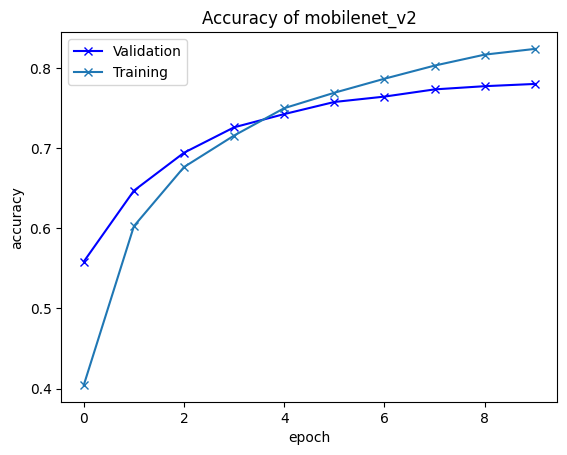

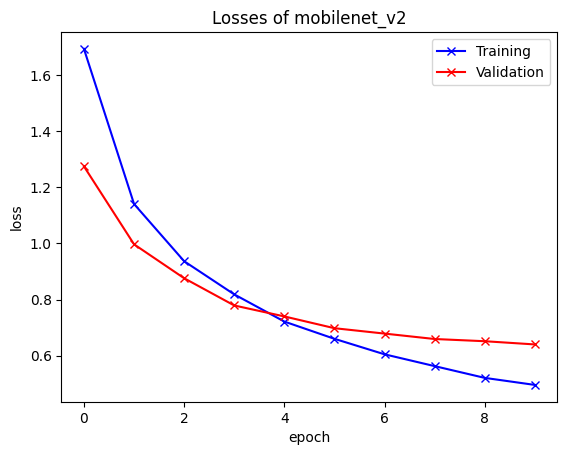

best acc in mobilenet_v2
{'val_loss': 0.6402623653411865, 'val_acc': 0.7801000475883484}


In [21]:
run(mobile_net)

ShuffleNet v2

Epoch [1], train_loss: 2.2876, train_acc: 0.1769, val_loss: 2.2693, val_acc: 0.2592
Epoch [2], train_loss: 2.2417, train_acc: 0.3125, val_loss: 2.2074, val_acc: 0.3510
Epoch [3], train_loss: 2.1465, train_acc: 0.3763, val_loss: 2.0796, val_acc: 0.4082
Epoch [4], train_loss: 1.9966, train_acc: 0.4205, val_loss: 1.9137, val_acc: 0.4528
Epoch [5], train_loss: 1.7991, train_acc: 0.4630, val_loss: 1.6895, val_acc: 0.4950
Epoch [6], train_loss: 1.5807, train_acc: 0.5031, val_loss: 1.4803, val_acc: 0.5324
Epoch [7], train_loss: 1.3934, train_acc: 0.5395, val_loss: 1.3201, val_acc: 0.5683
Epoch [8], train_loss: 1.2487, train_acc: 0.5882, val_loss: 1.1892, val_acc: 0.6043
Epoch [9], train_loss: 1.1175, train_acc: 0.6308, val_loss: 1.0800, val_acc: 0.6375
Epoch [10], train_loss: 1.0095, train_acc: 0.6625, val_loss: 0.9985, val_acc: 0.6611
Epoch [11], train_loss: 0.9337, train_acc: 0.6855, val_loss: 0.9447, val_acc: 0.6737
Epoch [12], train_loss: 0.8742, train_acc: 0.7049, val_loss: 0.9022, val_a

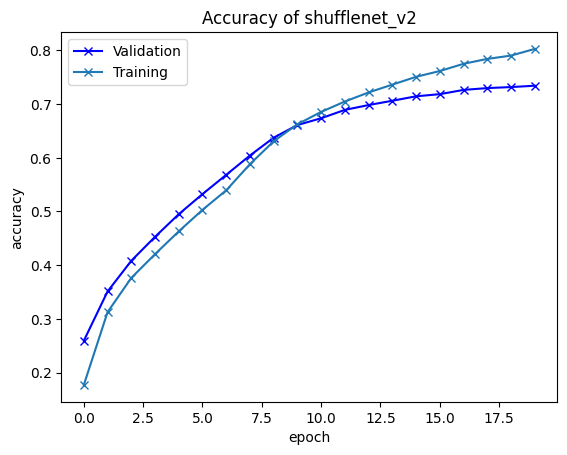

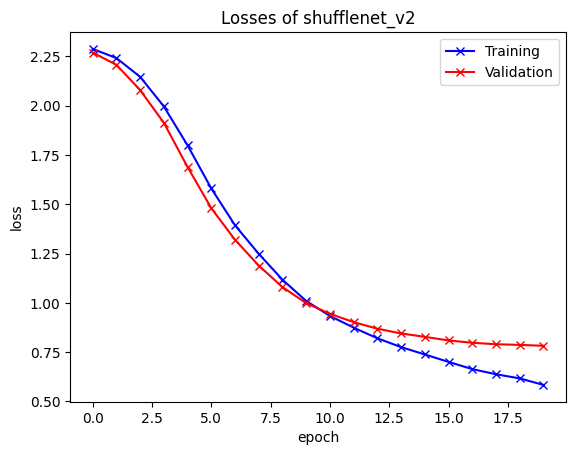

best acc in shufflenet_v2
{'val_loss': 0.7821124792098999, 'val_acc': 0.7343000173568726}


In [45]:
run(shuffle_net, epochs = 20)

Тестируем модели с модификациями и изображениями 224x224

In [ ]:
alex_net_mod = AlexNetMods(10)
res_next50_mod = ResNext50Mods(10)
mobile_net_mod = MobileNetV2Mods(10)
shuffle_net_mod = ShuffleNetV2Mods(10)

Epoch [1], train_loss: 0.7525, train_acc: 0.7369, val_loss: 0.5291, val_acc: 0.8105
Epoch [2], train_loss: 0.5747, train_acc: 0.7992, val_loss: 0.4802, val_acc: 0.8362
Epoch [3], train_loss: 0.5227, train_acc: 0.8181, val_loss: 0.4510, val_acc: 0.8450
Epoch [4], train_loss: 0.4870, train_acc: 0.8293, val_loss: 0.4420, val_acc: 0.8462
Epoch [5], train_loss: 0.4568, train_acc: 0.8396, val_loss: 0.4214, val_acc: 0.8513
Epoch [6], train_loss: 0.4315, train_acc: 0.8488, val_loss: 0.4065, val_acc: 0.8591
Epoch [7], train_loss: 0.4111, train_acc: 0.8558, val_loss: 0.4006, val_acc: 0.8617
Epoch [8], train_loss: 0.3937, train_acc: 0.8616, val_loss: 0.3919, val_acc: 0.8636
Epoch [9], train_loss: 0.3752, train_acc: 0.8691, val_loss: 0.3890, val_acc: 0.8659
Epoch [10], train_loss: 0.3605, train_acc: 0.8720, val_loss: 0.3792, val_acc: 0.8684
Epoch [11], train_loss: 0.3449, train_acc: 0.8774, val_loss: 0.3767, val_acc: 0.8704
Epoch [12], train_loss: 0.3323, train_acc: 0.8833, val_loss: 0.3757, val_a

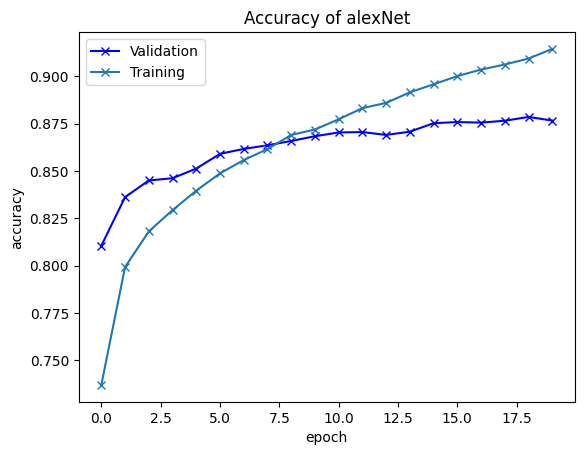

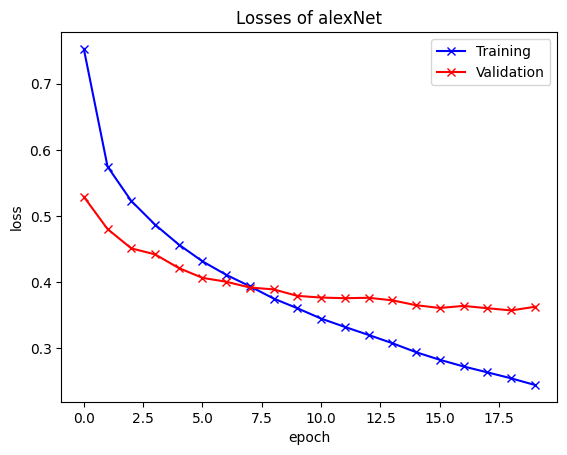

best acc in alexNet
{'val_loss': 0.3572791516780853, 'val_acc': 0.878600001335144}
CPU times: total: 8min 52s
Wall time: 12min 7s


In [ ]:
run(alex_net_mod)

Epoch [1], train_loss: 1.2926, train_acc: 0.6914, val_loss: 0.8823, val_acc: 0.7677
Epoch [2], train_loss: 0.8163, train_acc: 0.7683, val_loss: 0.7416, val_acc: 0.7801
Epoch [3], train_loss: 0.7189, train_acc: 0.7826, val_loss: 0.6790, val_acc: 0.7927
Epoch [4], train_loss: 0.6723, train_acc: 0.7913, val_loss: 0.6531, val_acc: 0.7948
Epoch [5], train_loss: 0.6442, train_acc: 0.7954, val_loss: 0.6215, val_acc: 0.8018
Epoch [6], train_loss: 0.6226, train_acc: 0.8000, val_loss: 0.6124, val_acc: 0.8045
Epoch [7], train_loss: 0.6057, train_acc: 0.8074, val_loss: 0.5971, val_acc: 0.8085
Epoch [8], train_loss: 0.5929, train_acc: 0.8090, val_loss: 0.5881, val_acc: 0.8111
Epoch [9], train_loss: 0.5803, train_acc: 0.8113, val_loss: 0.5771, val_acc: 0.8121
Epoch [10], train_loss: 0.5722, train_acc: 0.8136, val_loss: 0.5693, val_acc: 0.8140
Epoch [11], train_loss: 0.5629, train_acc: 0.8164, val_loss: 0.5603, val_acc: 0.8162
Epoch [12], train_loss: 0.5565, train_acc: 0.8188, val_loss: 0.5571, val_a

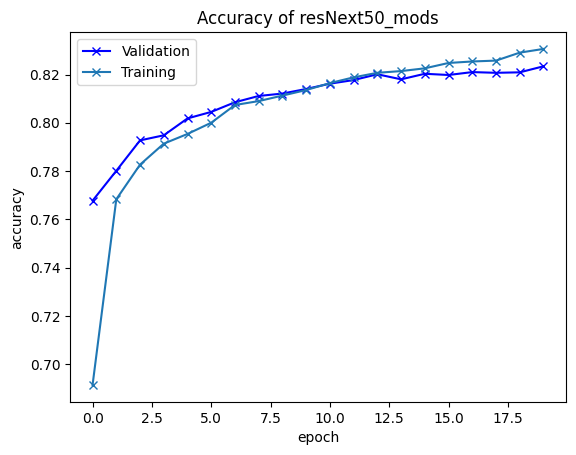

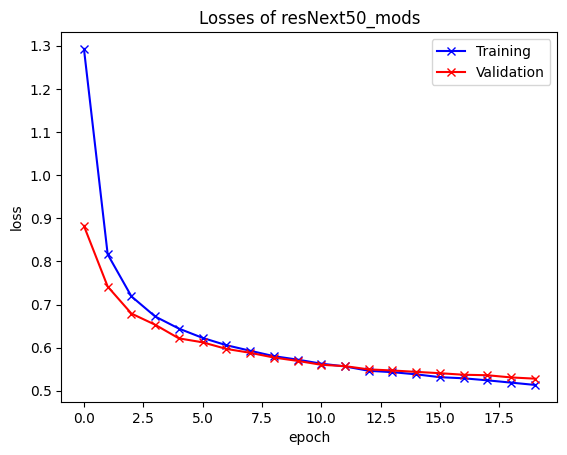

best acc in resNext50_mods
{'val_loss': 0.528128981590271, 'val_acc': 0.8234000205993652}
CPU times: total: 33min 20s
Wall time: 30min 50s


In [ ]:
run(res_next50_mod)

Epoch [1], train_loss: 1.4509, train_acc: 0.5914, val_loss: 0.9892, val_acc: 0.6819
Epoch [2], train_loss: 0.8376, train_acc: 0.7248, val_loss: 0.7735, val_acc: 0.7381
Epoch [3], train_loss: 0.7261, train_acc: 0.7533, val_loss: 0.6821, val_acc: 0.7653
Epoch [4], train_loss: 0.6498, train_acc: 0.7762, val_loss: 0.6773, val_acc: 0.7689
Epoch [5], train_loss: 0.6076, train_acc: 0.7904, val_loss: 0.5814, val_acc: 0.7999
Epoch [6], train_loss: 0.5719, train_acc: 0.8029, val_loss: 0.5672, val_acc: 0.8030
Epoch [7], train_loss: 0.5526, train_acc: 0.8095, val_loss: 0.5459, val_acc: 0.8146
Epoch [8], train_loss: 0.5225, train_acc: 0.8183, val_loss: 0.5180, val_acc: 0.8216
Epoch [9], train_loss: 0.5046, train_acc: 0.8254, val_loss: 0.5063, val_acc: 0.8262
Epoch [10], train_loss: 0.4820, train_acc: 0.8336, val_loss: 0.4881, val_acc: 0.8330
Epoch [11], train_loss: 0.4744, train_acc: 0.8364, val_loss: 0.4697, val_acc: 0.8372
Epoch [12], train_loss: 0.4582, train_acc: 0.8408, val_loss: 0.4605, val_a

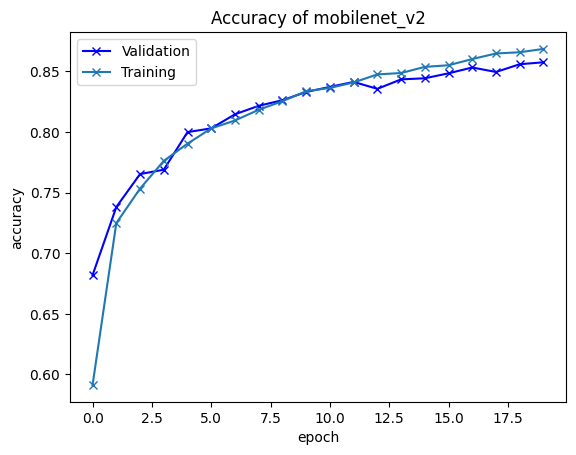

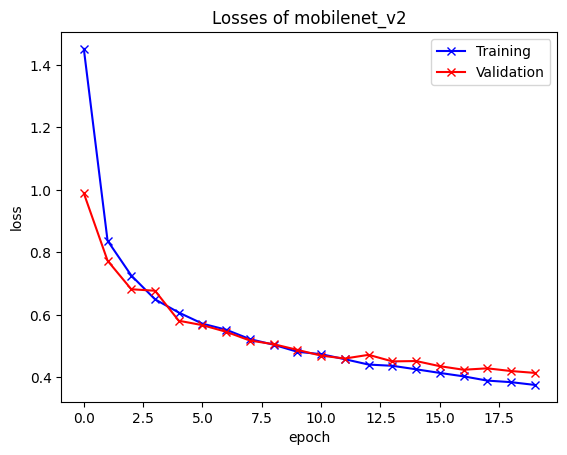

best acc in mobilenet_v2
{'val_loss': 0.41448214650154114, 'val_acc': 0.8575000166893005}
CPU times: total: 48min 19s
Wall time: 34min 48s


In [ ]:
run(mobile_net_mod, epochs = 20)

Epoch [1], train_loss: 2.2967, train_acc: 0.1665, val_loss: 2.2896, val_acc: 0.3030
Epoch [2], train_loss: 2.2832, train_acc: 0.4204, val_loss: 2.2761, val_acc: 0.5416
Epoch [3], train_loss: 2.2700, train_acc: 0.5817, val_loss: 2.2630, val_acc: 0.6339
Epoch [4], train_loss: 2.2568, train_acc: 0.6438, val_loss: 2.2496, val_acc: 0.6684
Epoch [5], train_loss: 2.2440, train_acc: 0.6654, val_loss: 2.2370, val_acc: 0.6924
Epoch [6], train_loss: 2.2311, train_acc: 0.6770, val_loss: 2.2239, val_acc: 0.7024
Epoch [7], train_loss: 2.2185, train_acc: 0.6972, val_loss: 2.2114, val_acc: 0.7141
Epoch [8], train_loss: 2.2058, train_acc: 0.7048, val_loss: 2.1990, val_acc: 0.7151
Epoch [9], train_loss: 2.1934, train_acc: 0.7104, val_loss: 2.1865, val_acc: 0.7178
Epoch [10], train_loss: 2.1809, train_acc: 0.7156, val_loss: 2.1741, val_acc: 0.7182
Epoch [11], train_loss: 2.1688, train_acc: 0.7140, val_loss: 2.1612, val_acc: 0.7168
Epoch [12], train_loss: 2.1566, train_acc: 0.7148, val_loss: 2.1502, val_a

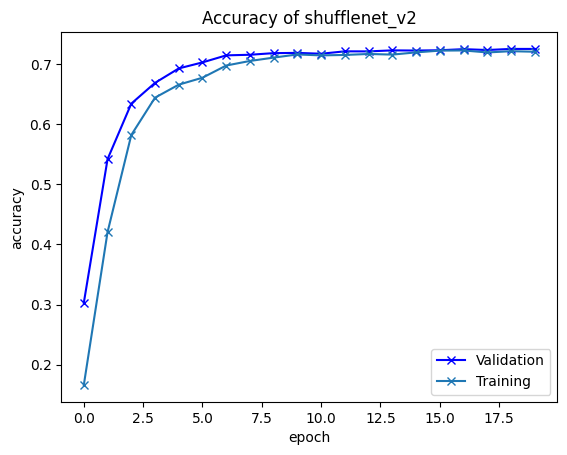

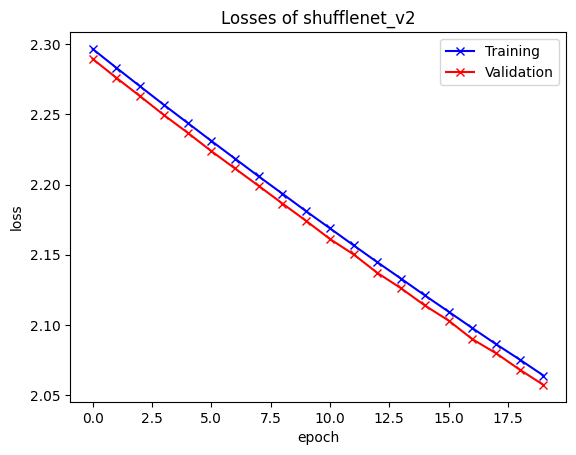

best acc in shufflenet_v2
{'val_loss': 2.0680129528045654, 'val_acc': 0.7247999310493469}
CPU times: total: 20min 34s
Wall time: 17min 17s


In [ ]:
run(shuffle_net_mod)